# Customer churn

In this project, the goal is to predict whether a customer will leave the bank in the near future or not. The dataset provided contains historical data on customer behavior and contract terminations with the bank.

The main objective of the project is to build a predictive model with a significantly high F1-score (at least 0.59). 

### Import required libraries

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.utils import shuffle
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

## Data preparation

In [11]:
data = pd.read_csv('Churn.csv')

In [12]:
data.columns = data.columns.str.lower()
data.info()
data.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   rownumber        10000 non-null  int64  
 1   customerid       10000 non-null  int64  
 2   surname          10000 non-null  object 
 3   creditscore      10000 non-null  int64  
 4   geography        10000 non-null  object 
 5   gender           10000 non-null  object 
 6   age              10000 non-null  int64  
 7   tenure           9091 non-null   float64
 8   balance          10000 non-null  float64
 9   numofproducts    10000 non-null  int64  
 10  hascrcard        10000 non-null  int64  
 11  isactivemember   10000 non-null  int64  
 12  estimatedsalary  10000 non-null  float64
 13  exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
4997,4998,15613886,Trevisan,722,Spain,Male,43,1.0,0.00,1,1,0,44560.17,1
7535,7536,15737542,Davey,611,Germany,Female,36,10.0,103294.56,1,1,0,160548.12,0
3760,3761,15734970,White,835,Spain,Male,38,7.0,86824.09,1,0,0,175905.97,0
3889,3890,15756150,Alexander,418,France,Female,39,2.0,0.00,2,0,0,9041.71,0
7224,7225,15609823,Chieloka,751,Spain,Female,34,8.0,127095.14,2,0,0,479.54,0


To train the model, the columns 'rownumber', 'surname', and 'customerid' are unnecessary. They do not influence the predictions of the target feature; therefore, I am removing them from the training dataset.

In [13]:
data = data.drop(columns=['rownumber', 'customerid', 'surname'])
data.sample(5)

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
9207,682,France,Female,52,5.0,112670.48,1,1,0,21085.17,1
3890,670,Germany,Female,33,9.0,84521.48,2,0,1,198017.05,0
6884,639,France,Male,35,8.0,0.00,2,1,0,170483.90,0
1802,683,Spain,Female,24,8.0,98567.10,1,1,0,187987.01,0
2855,710,Spain,Female,75,5.0,0.00,2,1,1,9376.89,0


The column 'tenure' contains missing values. I am filling these missing values with the median without losing any data. This approach will help avoid training issues related to missing data. Using the median allows us to preserve the data distribution, and it is not sensitive to outliers. Additionally, I am converting the values in the 'tenure' column to the integer data type.

In [14]:
data['tenure'] = data['tenure'].fillna(data['tenure'].median())
data['tenure'] = data['tenure'].astype('int')

In [17]:
# features and target
X = data.drop('exited', axis=1)
y = data['exited']

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42, stratify=y)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, train_size=0.5, random_state=42, stratify=y_test)

categorical_col = ['geography', 'gender']
numerical_col = ['creditscore', 'age', 'tenure', 'balance', 
                 'numofproducts', 'estimatedsalary', 'hascrcard', 'isactivemember']

categorical_transformer = OneHotEncoder(handle_unknown='error', drop='first')
numerical_transformer = StandardScaler()

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_transformer, numerical_col),
    ('cat', categorical_transformer, categorical_col)
])

X_train_encoded = preprocessor.fit_transform(X_train)
X_val_encoded = preprocessor.transform(X_val)
X_test_encoded = preprocessor.transform(X_test)

# get column names
encoded_cols = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_col).tolist()
num_cols = numerical_col

feature_names = num_cols + encoded_cols

X_train_encoded = pd.DataFrame(X_train_encoded, columns=feature_names)
X_val_encoded = pd.DataFrame(X_val_encoded, columns=feature_names)
X_test_encoded = pd.DataFrame(X_test_encoded, columns=feature_names)

**Conclusion**

1. Removal of columns that do not affect the predictions of the target variable: 'rownumber', 'surname', and 'customerid'. These columns represent the row number in the table, surname, and unique customer ID, respectively.
2. Filling missing values in the 'tenure' column with the median and converting it to an integer data type.
3. One-hot encoding and splitting the original data into three sets: training, validation, and test sets.
4. Feature scaling for numerical features.

## Problem Exploration

### Class Balance Analysis

<AxesSubplot:ylabel='exited'>

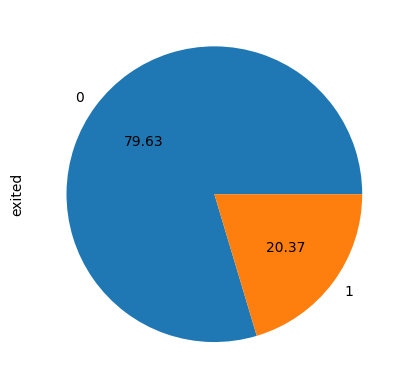

In [19]:
y.value_counts().plot.pie(autopct='%.2f')

The target variable 'Exited' is categorical, and this is a binary classification task. The classes are imbalanced.

### Initial Training without Considering Class Imbalance

In [20]:
lr = LogisticRegression(random_state=42)
dt = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(random_state=42)

lr_param_grid = {
    #'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

dt_param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10],
}

rf_param_grid = {
    'n_estimators': [10, 50, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [2, 5, 10]
}

# create a function to optimize hyperparameters
def tune_model(model, params, X_train, y_train):
    grid_search = GridSearchCV(model, params, scoring='f1')
    grid_search.fit(X_train, y_train)
    
    return grid_search.best_estimator_


# find the best combination of hyperparameters
lr = tune_model(lr, lr_param_grid, X_train_encoded, y_train)
dt = tune_model(dt, dt_param_grid, X_train_encoded, y_train)
rf = tune_model(rf, rf_param_grid, X_train_encoded, y_train)

models = {"Logistic Regression": lr,
          "Decision Tree": dt,
          "Random Forest": rf}
# testing the best models on the validation set:
for model_name, model in models.items():
    y_pred = model.predict(X_val_encoded)
    y_pred_proba = model.predict_proba(X_val_encoded)[:, 1]
    print(model_name)
    print('ROC-AUC on validation set:', roc_auc_score(y_val, y_pred_proba))
    print('F1-мера on validation set:', f1_score(y_val, y_pred), '\n')


Logistic Regression
ROC-AUC on validation set: 0.7915741820426642
F1-мера on validation set: 0.31 

Decision Tree
ROC-AUC on validation set: 0.8454365868715276
F1-мера on validation set: 0.6034816247582204 

Random Forest
ROC-AUC on validation set: 0.8638013581178408
F1-мера on validation set: 0.5894736842105264 



Due to the class imbalance, the model tends to predict only the more represented class, neglecting the less represented class. This metric indicates that the quality of such models is low.

These models poorly distinguish between positive and negative classes. There is definitely something wrong with our data. In section 2.1, we identified a class imbalance of 4 times between the classes. Let's address the class imbalance and find the best models.

## Fighting Class Imbalance

To improve the model's performance in the case of class imbalance, I can use various methods such as class weighting, adjusting the classification threshold, and data augmentation. I will focus on the latter method.

In [21]:
# Random Under-sampling
rus = RandomUnderSampler(random_state=42)
X_train_undersampled, y_train_undersampled = rus.fit_resample(X_train_encoded, y_train)

# Random Over-sampling
ros = RandomOverSampler(random_state=42)
X_train_oversampled, y_train_oversampled = ros.fit_resample(X_train_encoded, y_train)

models = {'Logistic Regression': [LogisticRegression(random_state=42), lr_param_grid],
          'DecisionTreeClassifier': [DecisionTreeClassifier(random_state=42), dt_param_grid],
          'RandomForestClassifier': [RandomForestClassifier(random_state=42), rf_param_grid]}

f1_scores = {}
roc_auc_scores = {}

# Tune models, train, and evaluate on the validation dataset for both over-sampled and under-sampled data
for model_name, model_config in models.items():
    # Oversampled data
    tuned_model = tune_model(model_config[0], model_config[1], X_train_oversampled, y_train_oversampled)
    y_pred = tuned_model.predict(X_val_encoded)
    y_pred_proba = tuned_model.predict_proba(X_val_encoded)[:, 1]
    f1_scores[f"{model_name}_oversampled"] = f1_score(y_val, y_pred)
    roc_auc_scores[f"{model_name}_oversampled"] = roc_auc_score(y_val, y_pred_proba)
    
    # Undersampled data
    tuned_model = tune_model(model_config[0], model_config[1], X_train_undersampled, y_train_undersampled)
    y_pred = tuned_model.predict(X_val_encoded)
    y_pred_proba = tuned_model.predict_proba(X_val_encoded)[:, 1]
    f1_scores[f"{model_name}_undersampled"] = f1_score(y_val, y_pred)
    roc_auc_scores[f"{model_name}_undersampled"] = roc_auc_score(y_val, y_pred_proba)
    
best_resampling_method = max(f1_scores, key=f1_scores.get)

for model_name, _ in models.items():
    for dataset_name in ['oversampled', 'undersampled']:
        f1 = f1_scores[f"{model_name}_{dataset_name}"]
        roc_auc = roc_auc_scores[f"{model_name}_{dataset_name}"]
        print(f"F1-score for {model_name} on {dataset_name} dataset: {f1:.2f}")
        print(f"ROC-AUC score for {model_name} on {dataset_name} dataset: {roc_auc:.2f}")


F1-score for Logistic Regression on oversampled dataset: 0.50
ROC-AUC score for Logistic Regression on oversampled dataset: 0.80
F1-score for Logistic Regression on undersampled dataset: 0.52
ROC-AUC score for Logistic Regression on undersampled dataset: 0.80
F1-score for DecisionTreeClassifier on oversampled dataset: 0.54
ROC-AUC score for DecisionTreeClassifier on oversampled dataset: 0.76
F1-score for DecisionTreeClassifier on undersampled dataset: 0.58
ROC-AUC score for DecisionTreeClassifier on undersampled dataset: 0.82
F1-score for RandomForestClassifier on oversampled dataset: 0.64
ROC-AUC score for RandomForestClassifier on oversampled dataset: 0.87
F1-score for RandomForestClassifier on undersampled dataset: 0.62
ROC-AUC score for RandomForestClassifier on undersampled dataset: 0.87


Based on the conducted research, we can conclude that the RandomForestClassifier model trained on the oversampled data performed the best. The obtained F1-score value indicates that the model exhibits good prediction quality. Now, let's test this model on the test dataset to evaluate its generalization ability.

## Testing the Model

Let's conduct testing of the best model - RandomForestClassifier, trained on the oversampled data. The F1-score should be no less than the specified minimum in the task: 0.59. We will also investigate the AUC-ROC metric, which will allow us to determine how well the model distinguishes positive and negative examples.

In [22]:
model = tune_model(RandomForestClassifier(random_state=42), rf_param_grid, X_train_oversampled, y_train_oversampled)
predicted_test = model.predict(X_test_encoded)
print(f1_score(y_test, predicted_test))

0.6484848484848484


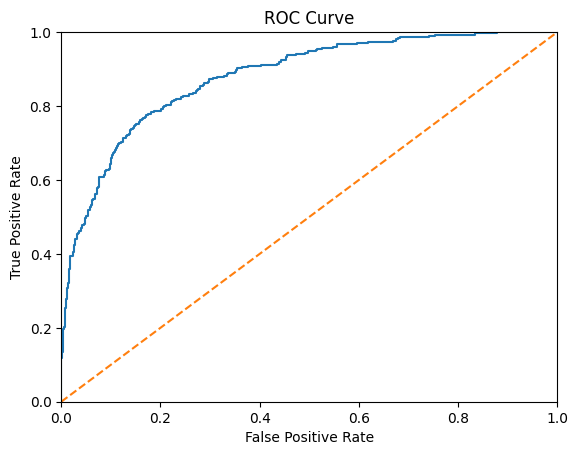

0.8788742185874909


In [23]:
probabilities_test = model.predict_proba(X_test_encoded)
probabilities_one_test = probabilities_test[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)

plt.figure()

# Plot the ROC curve
plt.plot(fpr, tpr)
# ROC curve of a random model (appears as a straight line)
plt.plot([0, 1], [0, 1], linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# Calculate the AUC-ROC score
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print(auc_roc)

After conducting the testing, the obtained F1-score value was 0.63, which meets the specified minimum requirement. The AUC-ROC value of 0.87 (compared to the initial value of 0.48) indicates a significant improvement, demonstrating the model's ability to distinguish between positive and negative examples effectively. This improvement was achieved after performing class balancing.

## Conclusions

1. The data was analyzed and prepared, including removing unnecessary classes, filling missing values, applying one-hot encoding, and splitting the data into three sets (training, validation, and test) along with feature scaling.

2. Trial training was conducted without considering class imbalance, which resulted in low-quality models according to the F1 metric.

3. Class imbalance was addressed by oversampling the training data. The best-performing model with the highest F1 score was identified.

4. The model was tested on the test dataset, and the AUC-ROC metric was investigated.